In [2]:
# Peter Karras 2020
'''Takes GPP and date information from old master file and creates a new Machine Learning Master File
   With one column representing file names for the converted CSVs and the other column being their respective
   GPPs as pulled from the old master file or calculated with linear interpolation'''

'Takes GPP and date information from old master file and creates a new Machine Learning Master File\n   With one column representing file names for the converted CSVs and the other column being their respective\n   GPPs as pulled from the old master file or calculated with linear interpolation'

In [87]:
import pandas as pd
import os
import csv
import time
import re


In [88]:
# Takes in a string that represents name of csv file and 
# converts that string to one that matches the date string present
# in the old master file (old master file refers to the raw excel file
# filled with extraneous data from BCI)that contains the date/times 
# for recorded GPP values
def change_csv_date(csv):
    minDivFiveFlag = True
    year = csv[2:4]
    month = csv[5:7]
    day = csv[8:10]
    hour = csv[11:13]
    minute = csv[14:16]
    second = "00"
    if (int(minute) % 5) != 0:
        print("THIS:", csv, "minute not divisible by 5")
        minDivFiveFlag = False
    if(int(hour) == 0):
        hour = "0"
    elif(int(hour) < 10):
        hour = hour[1:2]
    # No leading zeroes in day or month
    if(int(month) < 10):
        month = month[1:2]
    if(int(day) < 10):
        day = day[1:2]
    result = month + "/" + day + "/" + year + " " + hour + ":" + minute #+ ":" + second + " " + timeDay
    return result

# USE MAKE MASTER TO CREATE MULTIPLE populatedGPP files that hold mar, april, may etc

In [89]:
# Function that checks if time/date is at 00 minutes
def check_zero_time_min(csv):
    if csv[14:16] == "00":
        return True
    else:
        return False
#  and 30 minutes
def check_thirty_time_min(csv):
    if csv[14:16] == "30":
        return True
    else:
        return False
# and at specific hour
def check_spec_time_hour(csv, hour):
    if csv[11:13]==hour:
        return True
    else:
        return False

# Takes in csv date (in format 'YYYY_MM_DD_HH_MM_bci_t') and checks to see if minutes are divisble by div
def check_csv_date(csv, div):
    result = False
    minute = int(csv[14:16])
    remainder = minute % div
    if(remainder == 0):
        result = True
    else:
        result = False
    return result

# Get int value of hour
def get_hour_int(csv):
    return int(csv[11:13])

def get_min_int(csv):
    return int(csv[14:16])
    

# Takes in csv date (in format 'YYYY_MM_DD_HH_MM_bci_t') and checks to see if it falls within the "morning" 4:00am - 12:00pm
def time_check_csv_date(csv, regex):
    return not (None == regex.match(csv))

In [90]:
print(check_thirty_time_min("2015_03_14_12_30_bci_t.csv"))
print(check_spec_time_hour("2015_03_14_09_30_bci_t.csv","09"))
print(get_min_int("2015_03_14_09_59_bci_t.csv")%30)

True
True
29


In [123]:
'''
Set user inputed values
Date Format: YYYY_MM_DD_HH_MM_bci_t
'''
masterfileLocation = r"C:\Users\Peter\Desktop\Thermo_R_Code\FinalThermo\new2"
masterFileName = "all-30min-Apr2018_working.csv"
#regex_time_range = re.compile("2015_.._.._(0[4-9]_..|1[01]_..|12_00)_bci_t")
regex_time_range = re.compile("2015_.._.._(1[4-9]_..|20_00)_bci_t")
# 24 hour clock
pop_GPPS_file = "populatedGPPsNIGHT.csv"
graphTitle = "Night"

In [124]:
# Grabs all GPP values and dates from master file (as defined above)
masterfileLocation = r"C:\Users\Peter\Desktop\Thermo_R_Code\FinalThermo\new2"
os.chdir(masterfileLocation)
col_list = ["date", "GPP"]
masterFileName = "all-30min-Apr2018_working.csv"
dateGPPList = pd.read_csv(masterFileName, usecols=col_list) 
dateGPPList = dateGPPList.set_index("date")

# Create list of all avaialble thermal CSV values
csvdataLocation = r"C:\Users\Peter\Desktop\Thermo_R_Code\FinalThermo\new2\csvdataFULL\BCIML_Dataset"
(_, _, csvfiles) = next(os.walk(csvdataLocation))
# Remove any items that arent thermal image csv files (in this case filtering by file name)
csvfiles = [item for item in csvfiles if 'bci_t' in item]
# Remove files not within date range with regex
csvfiles = [item for item in csvfiles if time_check_csv_date(item,regex_time_range)]

######################################
"""
TESTING TEMPORARY
"""
# print(len(csvfiles))
# tempcsvfiles =list()
# for i in range(200):
#     print(csvfiles[i+194])
#     tempcsvfiles.append(csvfiles[i+194])
# csvfiles = tempcsvfiles
# print(csvfiles)
# print(len(csvfiles))
#########################################
len(csvfiles)
print(csvfiles[len(csvfiles)-1])


2015_09_30_20_00_bci_t.csv


In [125]:
list_dict_full = list()
csvfiles_iter = iter(csvfiles)
print(len(csvfiles))

current = next(csvfiles_iter, None)
while(True):
    counter += 1
    # End of files break condition
    if current == None:
        break
    # Increment until we hit the start of an appropriate interval start 
    # (one that has a corresponding recorded GPP value)
    while(current != None and (get_min_int(current)%30) != 0):
        current = next(csvfiles_iter, None)
    if current == None:
        break
        
    old_gpp = -101
    # Go through full time interval, doing linear interpolation where possible
    old_hour = get_hour_int(current)
    while (current != None and get_hour_int(current) >= old_hour):
        # If you are at the start of an interval, perform calculations for the next
        # 30 mins worth of values
        if get_min_int(current)%30 == 0:
            try:
                old_gpp = dateGPPList.at[change_csv_date(current),"GPP"]
            except KeyError:
                current = next(csvfiles_iter)
                old_hour = get_hour_int(current)
                continue
            list_dict_30min = list()
            list_dict_30min.append({"GPP":old_gpp, "FILE":current})
            # Move onto values after 00 or 30. (05,10... or 35,40...)
            # Add to list of dicts iff minutes divisible by 5
            current = next(csvfiles_iter, None)
            while len(list_dict_30min) < 6 and current != None and get_hour_int(current) >= old_hour:
                if(get_min_int(current)%5 == 0):
                    list_dict_30min.append({"GPP":-101, "FILE":current})
                old_hour = get_hour_int(current)
                current = next(csvfiles_iter, None)
            if current == None:
                break
            while get_min_int(current)%5 != 0:
                current = next(csvfiles_iter, None)
            # On exit of inner loop we have a list of values with minute values that look like:
            # 00 05 10 15 20 25 or 30 35 40 45 50 55
            if current == None or len(list_dict_30min) < 6:
                break
            else:
                try:
                    increment = (dateGPPList.at[change_csv_date(current),"GPP"] - list_dict_30min[0]['GPP'])/6.0
                except KeyError:
                    old_hour = get_hour_int(current)
                    continue
                for i in range(1,6):
                    temp_gpp_val = list_dict_30min[i-1]['GPP']+increment
                    list_dict_30min[i].update({'GPP':temp_gpp_val})
                list_dict_full.extend(list_dict_30min)
        else:
            current = next(csvfiles_iter, None)
        if current != None:
            old_hour = get_hour_int(current)
        else:
            break
            
    # If list incomplete we have ticked into next day
    if len(list_dict_30min) < 6:
        continue
        
    # Iterate to next element
    current = next(csvfiles_iter, None)

print(len(list_dict_full))

14126
10872


In [119]:
print(len(list_dict_full))

14160


In [134]:
print(os.getcwd())
MONTH_NAME = "NOn"
n_epochs = 5
batch_size = 6
idNum = "123"
file1 = open("stats_"+MONTH_NAME+"_"+idNum+".txt","a")
file1.write("Epochs: " + str(n_epochs) +"\n")
file1.write("Batch Size: " + str(batch_size))
file1.close()

C:\Users\Peter\Desktop\Thermo_R_Code\FinalThermo\new2


In [120]:
# This writes a NEW master file, with one column containing the
# thermal csv file names, and the other column containing their
# GPP values as determined from previous code. New file name is 
# determined by variable pop_GPPS_file

import csv
saveLocation = csvdataLocation
os.chdir(saveLocation)
#pop_GPPS_file = "populatedGPPs.csv"
#pop_GPPS_file = input("Please type what you like the populatedGPP file to be called:")
csv_columns = ['FILE','GPP']
try:
    with open(pop_GPPS_file, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n', fieldnames=csv_columns)
        writer.writeheader()
        for data in list_dict_full:
            writer.writerow(data)
except IOError:
    print("I/O error")
    


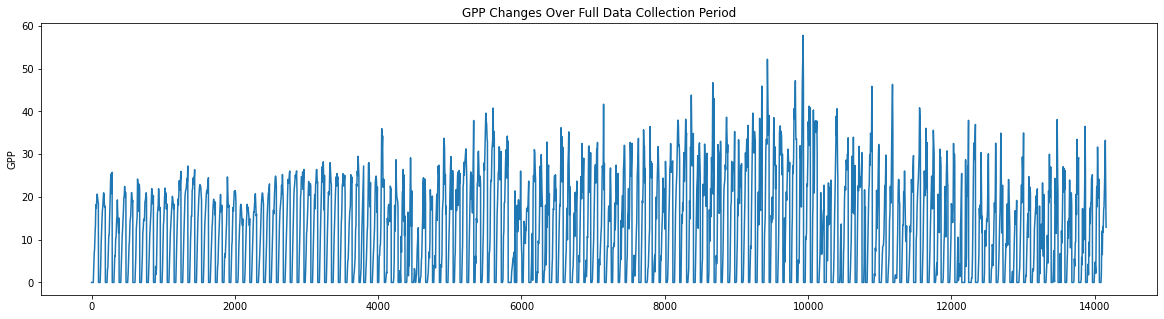

<Figure size 1440x360 with 0 Axes>

In [121]:
import numpy as np
import matplotlib.pyplot as plt

csv_master_path = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdataFULL/BCIML_Dataset/populatedGPPsMORN.csv"
#csv_master_path = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdata10000/populatedGPPs.csv"
data_info = pd.read_csv(csv_master_path)
GPP_arr = np.asarray(data_info.iloc[:,1])
fig=plt.figure(figsize=(20.0, 5.0))
plt.plot(GPP_arr)
plt.ylabel('GPP')
plt.title("GPP Changes Over Full Data Collection Period")
plt.figure(figsize=(20,5))
os.chdir(r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2")
plt.show()
os.chdir(csvdataLocation)

my_dpi=96

fig.savefig(graphTitle+' GPP Changes.png', dpi=my_dpi*5)